In [1]:
import os 
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable 
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [3]:
import matplotlib.pyplot as plt

# Creating spark session

In [5]:
conf_spark = SparkConf().set("spark.driver.host", "127.0.0.1")
spark = SparkSession.builder.appName("Testing PySpark Example").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/25 11:31:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/25 11:31:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Loading ml data 


In [7]:
#multilinear data set, as there are multiple features

housing_data = spark\
 .read\
 .option("inferSchema", "true")\
 .option("header", "true")\
 .csv("/Users/prateekpaul/Downloads/Housing.csv")


print(housing_data.columns)
x_cols = ['area']      # 'bedrooms']
y_col = 'price'

['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


# Preprocessing for LR

In [9]:
# preparing data for machine learning requires all features to be in a single vector column
# Vectorassembler is a transformer in Pyspark used to combine multiple feature coulumns into a single vector column

assembler = VectorAssembler(inputCols=x_cols, outputCol='features') 

# inputCols=x_cols: This is a list of column names that contain the individual features (inputs)
# outputCol='features': This specifies the name of the new column that will contain the vectorized features. 


df = assembler.transform(housing_data)

# After this transformation, a new column named features will be created in the DataFrame.

In [10]:
df['features']

Column<'features'>

In [11]:

train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# 70% of the data will go to the training set, and 30% will be used for the test set.
# train_data to train your model and test_data to evaluate its performance later.
# Providing a seed ensures that the split is reproducible — meaning, if you run the code multiple times with the same seed, you'll get the same split of the data every time.

lr = LinearRegression(featuresCol='features', labelCol=y_col)

#This line creates an instance of the LinearRegression model from PySpark's MLlib 
#featuresCol='features', tells the LinearRegression model which column to use as the features
# The Linear Regression model uses this column to train on.
#labelCol=y_col, specifies which column to use as the label (the target variable we're trying to predict)

In [12]:
model = lr.fit(train_data)

# The fit() method is used to train the model. 
# It takes the training dataset (train_data) as input, which should contain both the features and the labels (target values).
# This method learns the relationship between the features and the target variable in the training data by finding the best-fitting line that minimizes the error

25/02/25 11:31:50 WARN Instrumentation: [2ad3b4ef] regParam is zero, which might cause numerical instability and overfitting.
25/02/25 11:31:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/02/25 11:31:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [34]:
predictions = model.transform(test_data)

#model is the trained Linear Regression model that you obtained after calling .fit(train_data) on the training data (train_data).
#This model has learned the relationship between the input features and the target variable (based on the training data),
#it now contains the learned coefficients and intercept, which it will use to make predictions.
#The transform() method applies the trained model (model) to new data (in this case, test_data), and makes predictions.

predictions.show()

+-------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+--------+------------------+
|  price|area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|features|        prediction|
+-------+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+--------+------------------+
|1750000|3850|       3|        1|      2|     yes|       no|      no|             no|             no|      0|      no|     unfurnished|[3850.0]| 4216153.227881096|
|1890000|1700|       3|        1|      2|     yes|       no|      no|             no|             no|      0|      no|     unfurnished|[1700.0]| 3230882.925774414|
|1960000|3420|       5|        1|      2|      no|       no|      no|             no|             no|      0|      no|     unfurnished|[3420.0]|  4019099.16745976|
|2100000|2400|  

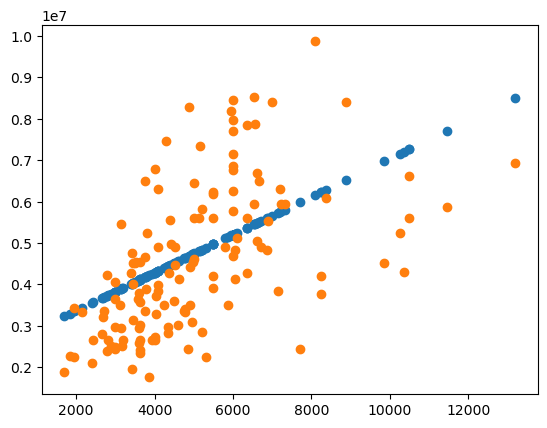

In [38]:
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# The predictions DataFrame contains the predicted values in a column named "prediction". This line selects that column from the predictions DataFrame.

x = test_data.select("features").rdd.flatMap(lambda x: x[0]).collect()
y_true = test_data.select("price").rdd.flatMap(lambda x: x).collect()
# y_true
plt.scatter(x, y_pred)
plt.scatter(x, y_true)


In [42]:
pred_result = model.evaluate(test_data)

In [44]:
pred_result.r2

0.28613415364503236